# Fun with Variational Autoencoders

This is a starter kernel to use **Labelled Faces in the Wild (LFW) Dataset** in order to maintain knowledge about main Autoencoder principles. PyTorch will be used for modelling.


### **Fork it and give it an upvote.**




![architecture](https://miro.medium.com/max/3636/1*LSYNW5m3TN7xRX61BZhoZA.png)

Useful links:


* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Introducing Variational Autoencoders (in Prose and Code)](https://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html)
* [How Autoencoders work - Understanding the math and implementation (Notebook)](https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases)
* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)



# A bit of theory

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

source: https://blog.keras.io/building-autoencoders-in-keras.html


In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

# Explore the data

In [3]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

person                                               path
0  Tyler_Hamilton  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1  Tyler_Hamilton  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2  Bernard_Siegel  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3   Blythe_Danner  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4   Blythe_Danner  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5   Gene_Robinson  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6   Gene_Robinson  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7   Gene_Robinson  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8   Gene_Robinson  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9   Gene_Robinson  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...

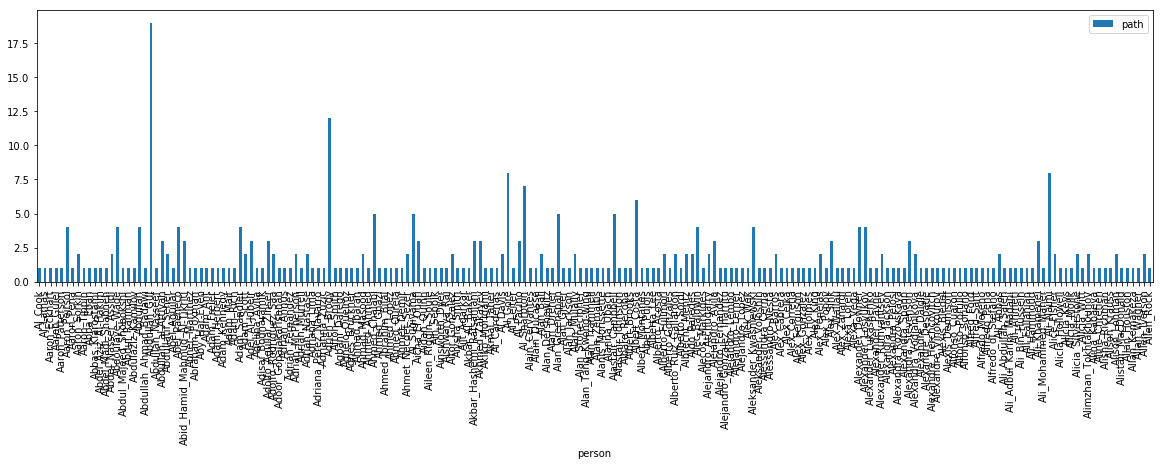

In [4]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

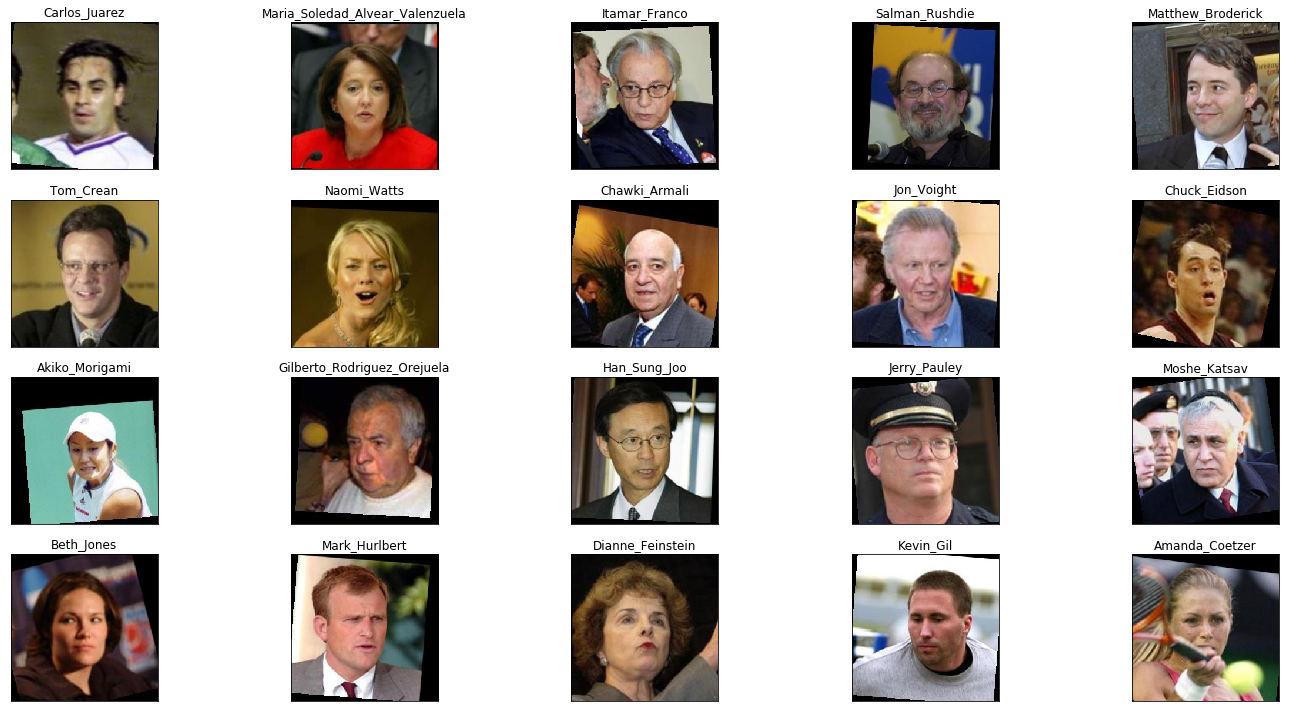

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Prepare the dataset

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [7]:
data, attrs = fetch_dataset()

In [8]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [9]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

# Building simple autoencoder

In [11]:
dim_z=100

In [12]:
X_train.shape

torch.Size([10514, 45, 45, 3])

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            #nn.Linear(500,1000),
            #nn.ReLU(),
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        encoded = self.encode(x) 
        decoded = self.decode(encoded)     
        return encoded, decoded

In [14]:
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5, stride=2)
        )
        
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        x = x.permute(0,3,1,2)
        encoded = self.encoder(x)  
        decoded = self.decode(encoded)     

        
        return encoded, decoded

In [15]:
model_auto = Autoencoder().to(DEVICE)

# Train autoencoder

In [16]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        #print('decoder shape: ', decoder.shape)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
        pic_input = pic_input.to(DEVICE)        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")        
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size,is_cnn)
            val_loss = eval_epoch(model,val_x,criterion, is_cnn)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   1%|▏         | 1/75 [00:00<01:08,  1.09it/s]

loss:  0.08383502203291568

Epoch 001 train_loss: 0.0838 val_loss: 0.0864


epoch:   3%|▎         | 2/75 [00:01<00:56,  1.28it/s]

loss:  0.03231117083937842

Epoch 002 train_loss: 0.0323 val_loss: 0.0210


epoch:   4%|▍         | 3/75 [00:01<00:49,  1.47it/s]

loss:  0.018345346752981485

Epoch 003 train_loss: 0.0183 val_loss: 0.0174


epoch:   5%|▌         | 4/75 [00:02<00:44,  1.61it/s]

loss:  0.016236081164537872

Epoch 004 train_loss: 0.0162 val_loss: 0.0156


epoch:   7%|▋         | 5/75 [00:02<00:40,  1.75it/s]

loss:  0.014931442369989497

Epoch 005 train_loss: 0.0149 val_loss: 0.0150


epoch:   8%|▊         | 6/75 [00:03<00:36,  1.87it/s]

loss:  0.01483085541972642

Epoch 006 train_loss: 0.0148 val_loss: 0.0149


epoch:   9%|▉         | 7/75 [00:03<00:34,  1.96it/s]

loss:  0.014626376840537698

Epoch 007 train_loss: 0.0146 val_loss: 0.0148


epoch:  11%|█         | 8/75 [00:04<00:33,  2.03it/s]

loss:  0.014686119156119509

Epoch 008 train_loss: 0.0147 val_loss: 0.0149


epoch:  12%|█▏        | 9/75 [00:04<00:31,  2.08it/s]

loss:  0.013882052661439687

Epoch 009 train_loss: 0.0139 val_loss: 0.0134


epoch:  13%|█▎        | 10/75 [00:05<00:30,  2.12it/s]

loss:  0.013264661865294354

Epoch 010 train_loss: 0.0133 val_loss: 0.0135


epoch:  15%|█▍        | 11/75 [00:05<00:29,  2.15it/s]

loss:  0.012720186801176233

Epoch 011 train_loss: 0.0127 val_loss: 0.0126


epoch:  16%|█▌        | 12/75 [00:05<00:29,  2.17it/s]

loss:  0.012345950692482484

Epoch 012 train_loss: 0.0123 val_loss: 0.0125


epoch:  17%|█▋        | 13/75 [00:06<00:28,  2.18it/s]

loss:  0.01225552841310937

Epoch 013 train_loss: 0.0123 val_loss: 0.0142


epoch:  19%|█▊        | 14/75 [00:06<00:27,  2.19it/s]

loss:  0.01340378417736403

Epoch 014 train_loss: 0.0134 val_loss: 0.0123


epoch:  20%|██        | 15/75 [00:07<00:27,  2.20it/s]

loss:  0.012090224412351205

Epoch 015 train_loss: 0.0121 val_loss: 0.0122


epoch:  21%|██▏       | 16/75 [00:07<00:26,  2.21it/s]

loss:  0.011694873455328669

Epoch 016 train_loss: 0.0117 val_loss: 0.0117


epoch:  23%|██▎       | 17/75 [00:08<00:26,  2.21it/s]

loss:  0.01161992959823443

Epoch 017 train_loss: 0.0116 val_loss: 0.0118


epoch:  24%|██▍       | 18/75 [00:08<00:25,  2.21it/s]

loss:  0.011403977624867915

Epoch 018 train_loss: 0.0114 val_loss: 0.0116


epoch:  25%|██▌       | 19/75 [00:09<00:25,  2.21it/s]

loss:  0.011326178629677662

Epoch 019 train_loss: 0.0113 val_loss: 0.0115


epoch:  27%|██▋       | 20/75 [00:09<00:24,  2.22it/s]

loss:  0.011398881321444482

Epoch 020 train_loss: 0.0114 val_loss: 0.0114


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
epoch:  28%|██▊       | 21/75 [00:09<00:24,  2.21it/s]

loss:  0.011055511308188036

Epoch 021 train_loss: 0.0111 val_loss: 0.0110


epoch:  29%|██▉       | 22/75 [00:10<00:25,  2.11it/s]

loss:  0.011535063705203174

Epoch 022 train_loss: 0.0115 val_loss: 0.0112


epoch:  31%|███       | 23/75 [00:10<00:24,  2.14it/s]

loss:  0.010903545805009142

Epoch 023 train_loss: 0.0109 val_loss: 0.0114


epoch:  32%|███▏      | 24/75 [00:11<00:23,  2.14it/s]

loss:  0.010745168630078376

Epoch 024 train_loss: 0.0107 val_loss: 0.0106


epoch:  33%|███▎      | 25/75 [00:11<00:23,  2.16it/s]

loss:  0.010466181743972958

Epoch 025 train_loss: 0.0105 val_loss: 0.0105


epoch:  35%|███▍      | 26/75 [00:12<00:22,  2.18it/s]

loss:  0.010292839996774647

Epoch 026 train_loss: 0.0103 val_loss: 0.0106


epoch:  36%|███▌      | 27/75 [00:12<00:21,  2.19it/s]

loss:  0.010278680036012747

Epoch 027 train_loss: 0.0103 val_loss: 0.0105


epoch:  37%|███▋      | 28/75 [00:13<00:21,  2.14it/s]

loss:  0.010901783437985237

Epoch 028 train_loss: 0.0109 val_loss: 0.0105


epoch:  39%|███▊      | 29/75 [00:13<00:21,  2.15it/s]

loss:  0.010122891101650986

Epoch 029 train_loss: 0.0101 val_loss: 0.0102


epoch:  40%|████      | 30/75 [00:14<00:20,  2.17it/s]

loss:  0.010261678481458574

Epoch 030 train_loss: 0.0103 val_loss: 0.0102


epoch:  41%|████▏     | 31/75 [00:14<00:20,  2.18it/s]

loss:  0.009881848630059382

Epoch 031 train_loss: 0.0099 val_loss: 0.0105


epoch:  43%|████▎     | 32/75 [00:15<00:19,  2.20it/s]

loss:  0.009930636070311546

Epoch 032 train_loss: 0.0099 val_loss: 0.0104


epoch:  44%|████▍     | 33/75 [00:15<00:19,  2.20it/s]

loss:  0.009706408199435215

Epoch 033 train_loss: 0.0097 val_loss: 0.0096


epoch:  45%|████▌     | 34/75 [00:15<00:18,  2.21it/s]

loss:  0.009821832736832563

Epoch 034 train_loss: 0.0098 val_loss: 0.0096


epoch:  47%|████▋     | 35/75 [00:16<00:18,  2.21it/s]

loss:  0.009341902367767838

Epoch 035 train_loss: 0.0093 val_loss: 0.0094


epoch:  48%|████▊     | 36/75 [00:16<00:17,  2.22it/s]

loss:  0.009620507945219259

Epoch 036 train_loss: 0.0096 val_loss: 0.0093


epoch:  49%|████▉     | 37/75 [00:17<00:17,  2.22it/s]

loss:  0.008992507956165232

Epoch 037 train_loss: 0.0090 val_loss: 0.0095


epoch:  51%|█████     | 38/75 [00:17<00:16,  2.22it/s]

loss:  0.009093743455765455

Epoch 038 train_loss: 0.0091 val_loss: 0.0090


epoch:  52%|█████▏    | 39/75 [00:18<00:16,  2.22it/s]

loss:  0.008801569428917787

Epoch 039 train_loss: 0.0088 val_loss: 0.0089


epoch:  53%|█████▎    | 40/75 [00:18<00:15,  2.22it/s]

loss:  0.008947083443957397

Epoch 040 train_loss: 0.0089 val_loss: 0.0091


epoch:  55%|█████▍    | 41/75 [00:19<00:15,  2.22it/s]

loss:  0.008653396428225213

Epoch 041 train_loss: 0.0087 val_loss: 0.0091


epoch:  56%|█████▌    | 42/75 [00:19<00:14,  2.22it/s]

loss:  0.009352752515280487

Epoch 042 train_loss: 0.0094 val_loss: 0.0088


epoch:  57%|█████▋    | 43/75 [00:20<00:14,  2.22it/s]

loss:  0.0084348368597165

Epoch 043 train_loss: 0.0084 val_loss: 0.0085


epoch:  59%|█████▊    | 44/75 [00:20<00:13,  2.22it/s]

loss:  0.00863205236080727

Epoch 044 train_loss: 0.0086 val_loss: 0.0086


epoch:  60%|██████    | 45/75 [00:20<00:13,  2.22it/s]

loss:  0.008336407325903919

Epoch 045 train_loss: 0.0083 val_loss: 0.0085


epoch:  61%|██████▏   | 46/75 [00:21<00:13,  2.22it/s]

loss:  0.008217333798807498

Epoch 046 train_loss: 0.0082 val_loss: 0.0084


epoch:  63%|██████▎   | 47/75 [00:21<00:12,  2.22it/s]

loss:  0.008349089181897121

Epoch 047 train_loss: 0.0083 val_loss: 0.0096


epoch:  64%|██████▍   | 48/75 [00:22<00:12,  2.22it/s]

loss:  0.008365486146000281

Epoch 048 train_loss: 0.0084 val_loss: 0.0085


epoch:  65%|██████▌   | 49/75 [00:22<00:11,  2.18it/s]

loss:  0.008322120094429139

Epoch 049 train_loss: 0.0083 val_loss: 0.0084


epoch:  67%|██████▋   | 50/75 [00:23<00:11,  2.13it/s]

loss:  0.00817568263806798

Epoch 050 train_loss: 0.0082 val_loss: 0.0095


epoch:  68%|██████▊   | 51/75 [00:23<00:11,  2.12it/s]

loss:  0.008341276495217348

Epoch 051 train_loss: 0.0083 val_loss: 0.0084


epoch:  69%|██████▉   | 52/75 [00:24<00:11,  2.07it/s]

loss:  0.0079673056781968

Epoch 052 train_loss: 0.0080 val_loss: 0.0080


epoch:  71%|███████   | 53/75 [00:24<00:10,  2.10it/s]

loss:  0.008220330980691944

Epoch 053 train_loss: 0.0082 val_loss: 0.0082


epoch:  72%|███████▏  | 54/75 [00:25<00:09,  2.13it/s]

loss:  0.007789825795252717

Epoch 054 train_loss: 0.0078 val_loss: 0.0080


epoch:  73%|███████▎  | 55/75 [00:25<00:09,  2.15it/s]

loss:  0.007776854445334734

Epoch 055 train_loss: 0.0078 val_loss: 0.0080


epoch:  75%|███████▍  | 56/75 [00:26<00:08,  2.17it/s]

loss:  0.00850216625214037

Epoch 056 train_loss: 0.0085 val_loss: 0.0082


epoch:  76%|███████▌  | 57/75 [00:26<00:08,  2.04it/s]

loss:  0.007735941747573022

Epoch 057 train_loss: 0.0077 val_loss: 0.0079


epoch:  77%|███████▋  | 58/75 [00:27<00:08,  2.09it/s]

loss:  0.007591720575416084

Epoch 058 train_loss: 0.0076 val_loss: 0.0077


epoch:  79%|███████▊  | 59/75 [00:27<00:07,  2.13it/s]

loss:  0.007637826688017215

Epoch 059 train_loss: 0.0076 val_loss: 0.0079


epoch:  80%|████████  | 60/75 [00:27<00:06,  2.15it/s]

loss:  0.007570096431468345

Epoch 060 train_loss: 0.0076 val_loss: 0.0079


epoch:  81%|████████▏ | 61/75 [00:28<00:06,  2.17it/s]

loss:  0.007552440917065882

Epoch 061 train_loss: 0.0076 val_loss: 0.0077


epoch:  83%|████████▎ | 62/75 [00:28<00:05,  2.18it/s]

loss:  0.007885157893946303

Epoch 062 train_loss: 0.0079 val_loss: 0.0079


epoch:  84%|████████▍ | 63/75 [00:29<00:05,  2.20it/s]

loss:  0.007618031406852003

Epoch 063 train_loss: 0.0076 val_loss: 0.0077


epoch:  85%|████████▌ | 64/75 [00:29<00:04,  2.20it/s]

loss:  0.00748001231174347

Epoch 064 train_loss: 0.0075 val_loss: 0.0088


epoch:  87%|████████▋ | 65/75 [00:30<00:04,  2.21it/s]

loss:  0.007814507469529913

Epoch 065 train_loss: 0.0078 val_loss: 0.0078


epoch:  88%|████████▊ | 66/75 [00:30<00:04,  2.21it/s]

loss:  0.007391480646427988

Epoch 066 train_loss: 0.0074 val_loss: 0.0075


epoch:  89%|████████▉ | 67/75 [00:31<00:03,  2.21it/s]

loss:  0.007781159203493887

Epoch 067 train_loss: 0.0078 val_loss: 0.0077


epoch:  91%|█████████ | 68/75 [00:31<00:03,  2.21it/s]

loss:  0.0073808040388391935

Epoch 068 train_loss: 0.0074 val_loss: 0.0076


epoch:  92%|█████████▏| 69/75 [00:32<00:02,  2.21it/s]

loss:  0.007308172704239172

Epoch 069 train_loss: 0.0073 val_loss: 0.0074


epoch:  93%|█████████▎| 70/75 [00:32<00:02,  2.21it/s]

loss:  0.007938663330831205

Epoch 070 train_loss: 0.0079 val_loss: 0.0083


epoch:  95%|█████████▍| 71/75 [00:32<00:01,  2.21it/s]

loss:  0.007422609283063197

Epoch 071 train_loss: 0.0074 val_loss: 0.0075


epoch:  96%|█████████▌| 72/75 [00:33<00:01,  2.21it/s]

loss:  0.007141452129513581

Epoch 072 train_loss: 0.0071 val_loss: 0.0074


epoch:  97%|█████████▋| 73/75 [00:33<00:00,  2.21it/s]

loss:  0.007355966532256738

Epoch 073 train_loss: 0.0074 val_loss: 0.0079


epoch:  99%|█████████▊| 74/75 [00:34<00:00,  2.21it/s]

loss:  0.007308995910396345

Epoch 074 train_loss: 0.0073 val_loss: 0.0073


epoch: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s]

loss:  0.0070530343514672075

Epoch 075 train_loss: 0.0071 val_loss: 0.0073


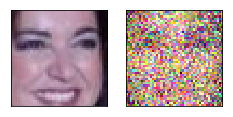

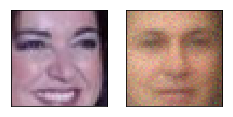

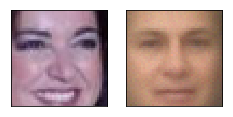

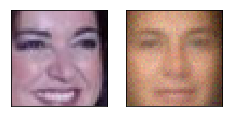

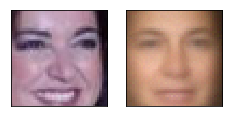

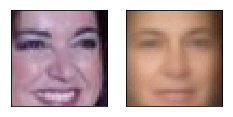

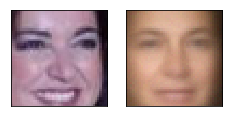

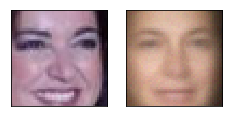

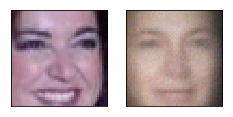

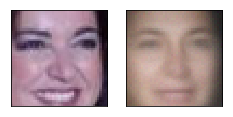

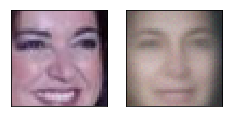

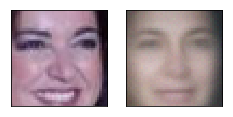

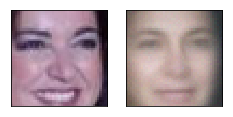

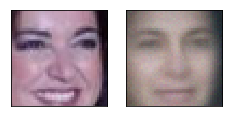

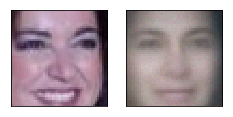

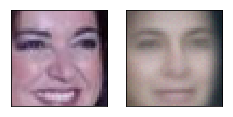

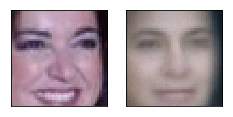

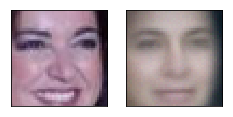

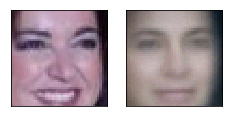

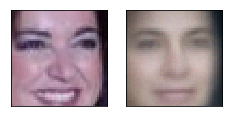

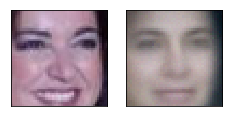

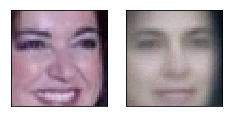

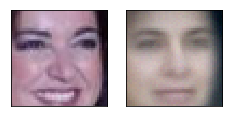

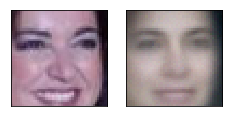

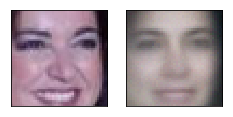

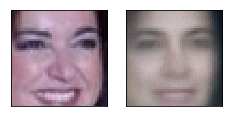

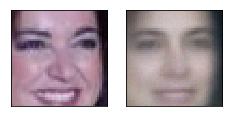

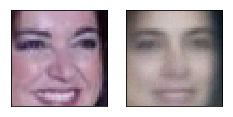

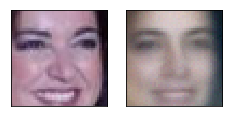

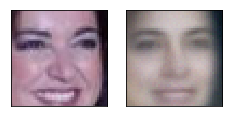

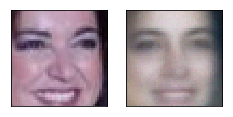

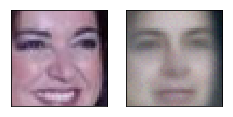

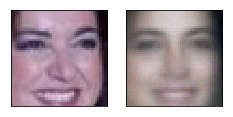

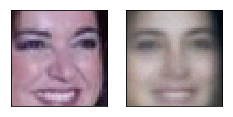

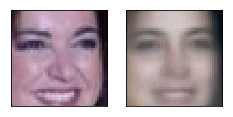

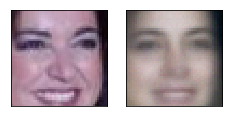

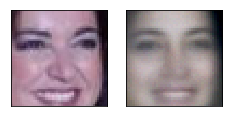

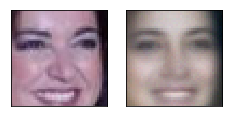

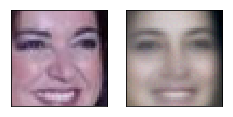

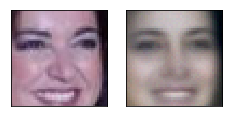

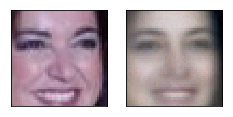

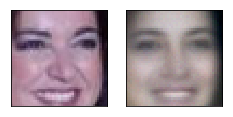

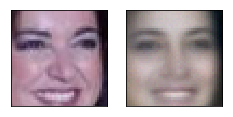

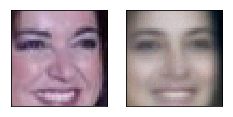

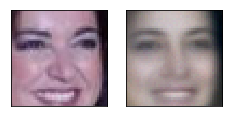

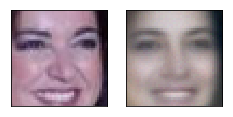

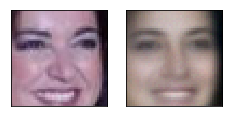

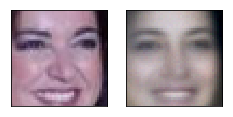

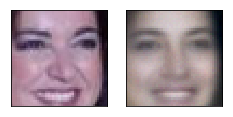

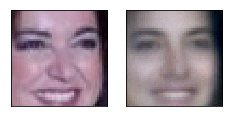

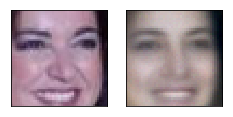

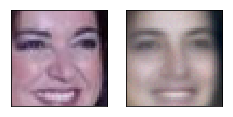

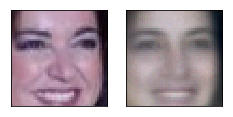

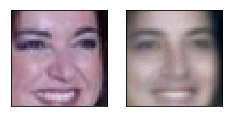

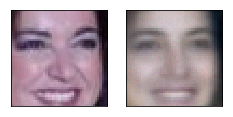

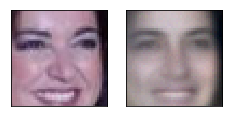

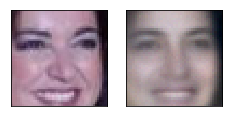

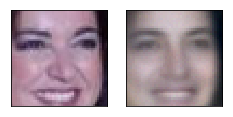

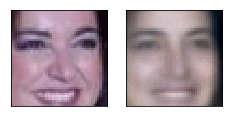

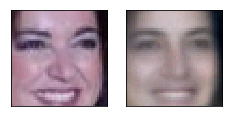

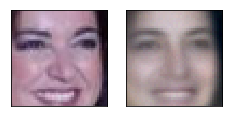

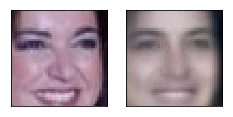

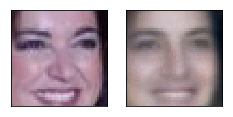

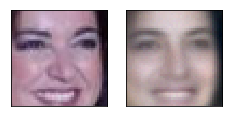

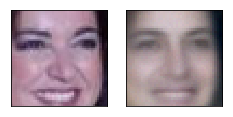

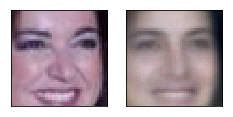

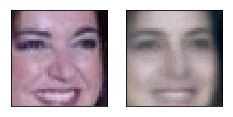

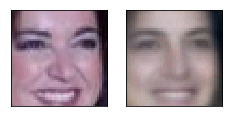

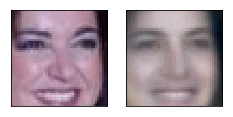

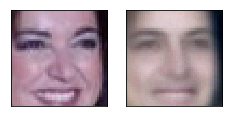

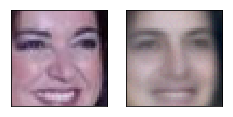

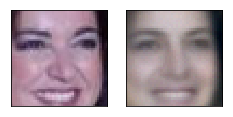

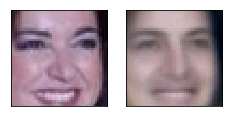

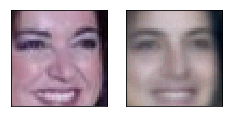

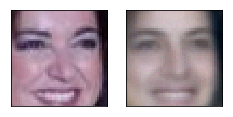

In [17]:
history = train(X_train, X_val, model_auto, epochs=75, batch_size=512)

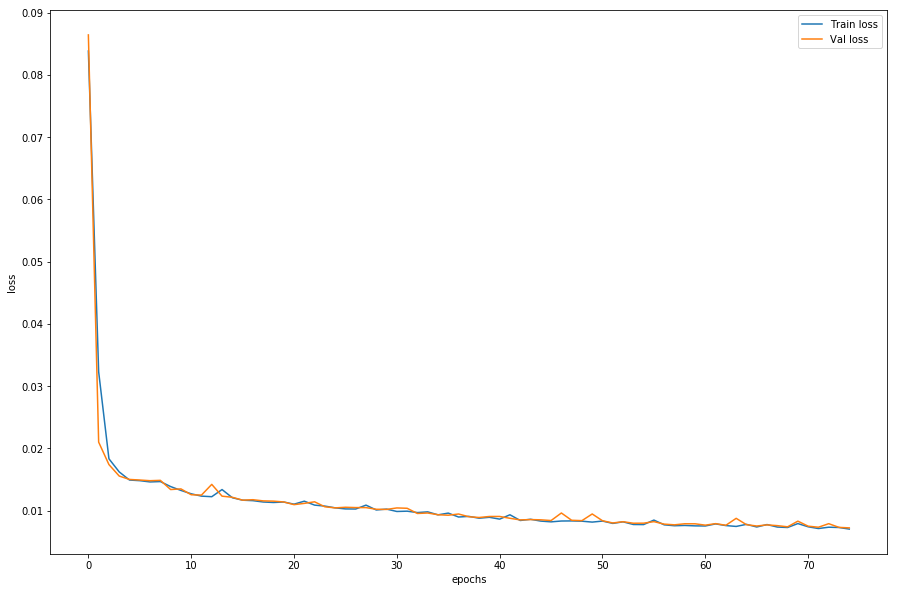

In [18]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

# Sampling

Let's generate some samples from random vectors

(25, 100)


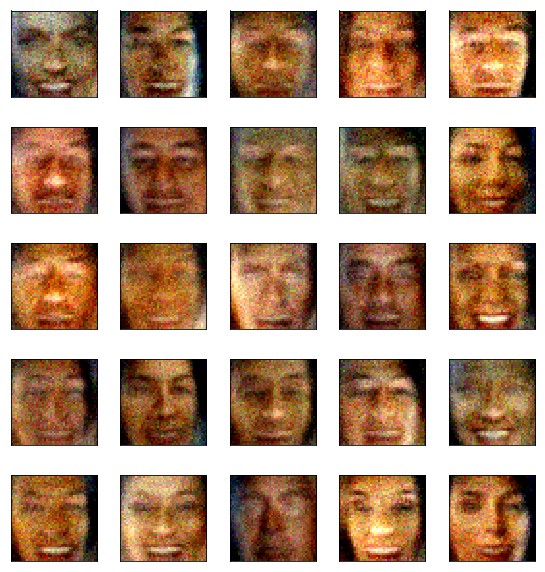

In [19]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_auto.eval()
    output = model_auto.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

# Adding smile and glasses

Let's find some attributes like smiles or glasses on the photo and try to add it to the photos which don't have it. We will use the second dataset for it. It contains a bunch of such attributes. 

In [20]:
attrs.head()

Male     Asian     White     Black     Baby     Child      Youth  \
0   1.56835  -1.88904    1.7372 -0.929729  -1.4718  -0.19558  -0.835609   
1  0.169851 -0.982408  0.422709  -1.28218 -1.36006 -0.867002  -0.452293   
2  0.997749  -1.36419 -0.157377 -0.756447 -1.89183 -0.871526  -0.862893   
3   1.12272   -1.9978   1.91614  -2.51421 -2.58007  -1.40424  0.0575511   
4   1.07821   -2.0081   1.67621  -2.27806 -2.65185  -1.34841   0.649089   

   Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0    -0.351468  -1.01253  -0.719593  ...  0.361738           1.16612   
1    -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.0314447  -1.34152 -0.0900375  ...   1.54974           1.88475   
3  0.000195882  -1.27351   -1.43146  ...  0.567822         -0.176089   
4    0.0176564  -1.88911   -1.85721  ...  -1.46147         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0                -1.16492         -1.13999     -2.37175        -1.29993   
1                 0.87416        -0.945431    -0.268649     -0.00624408   
2               -0.999765         -1.35986     -1.91211        -1.09563   
3                 1.10812         -1.60094     -3.26461        0.813418   
4                0.119113         -1.12818     -3.16105       0.0826804   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682          -1.1449        0.694007        -0.826609  
1 -0.0304057        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [21]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [22]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

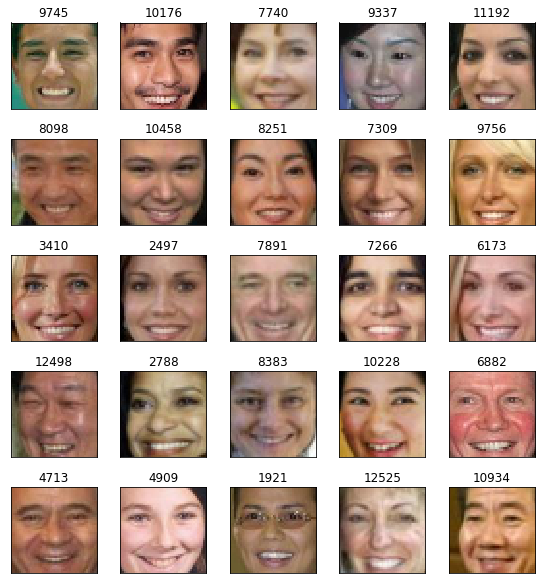

In [23]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

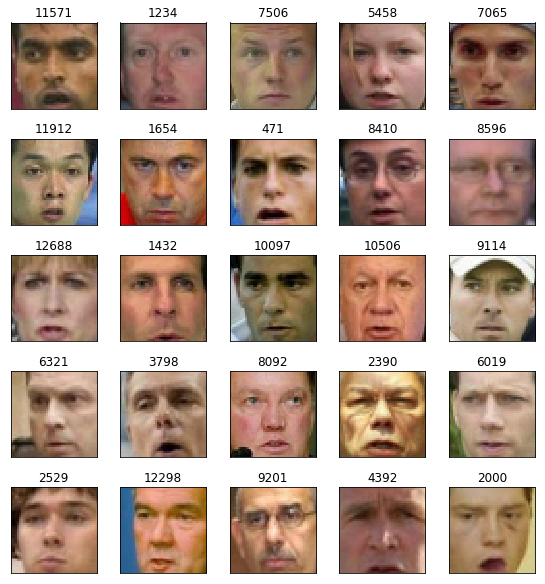

In [24]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

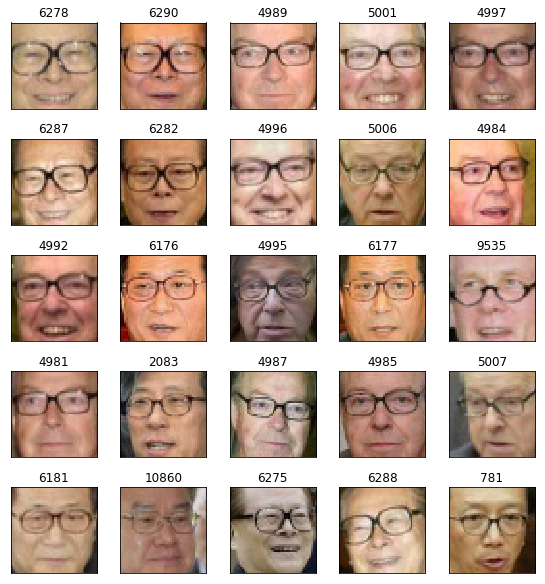

In [25]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

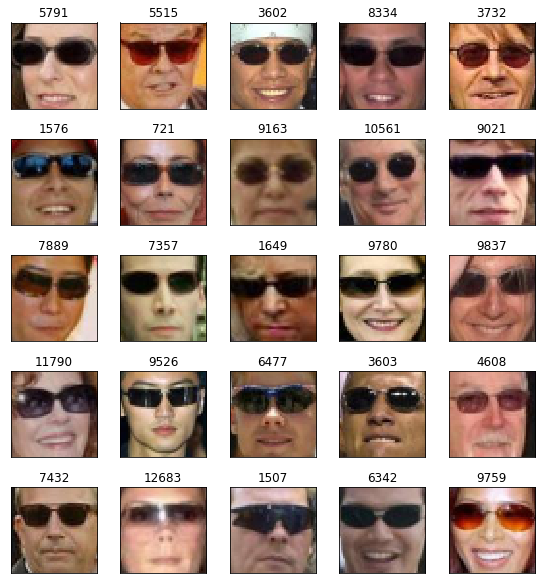

In [26]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

Calculating latent space vector for the selected images.

In [27]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_auto.eval()
        output = model_auto.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_auto.eval()
        output = model_auto.decode(inputs)        
        return output

In [28]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

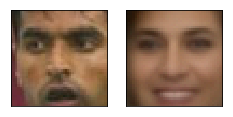

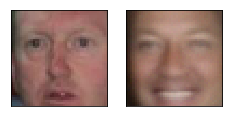

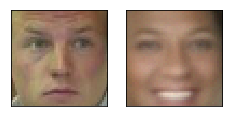

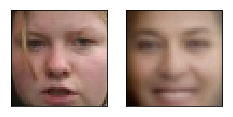

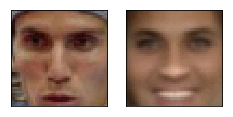

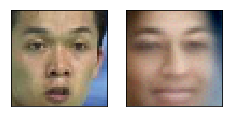

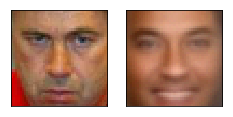

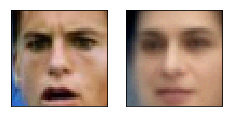

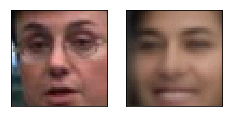

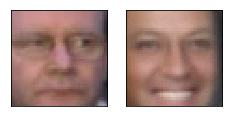

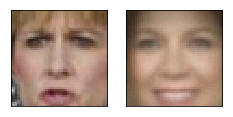

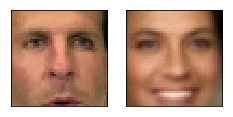

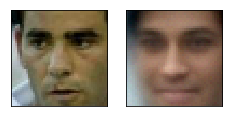

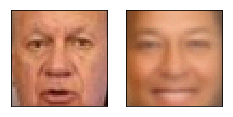

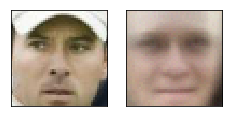

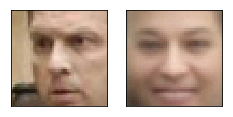

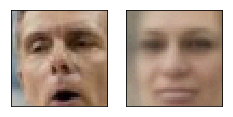

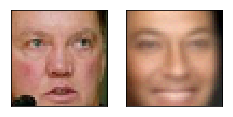

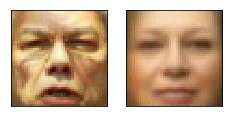

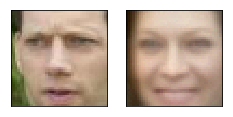

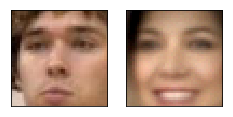

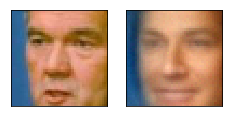

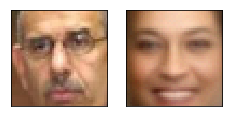

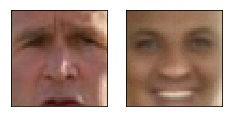

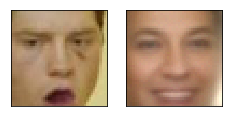

In [29]:
make_me_smile(no_smile_ids)

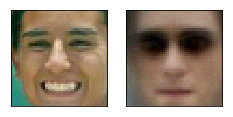

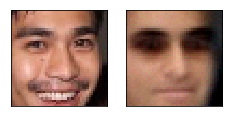

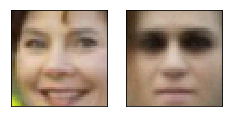

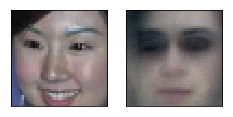

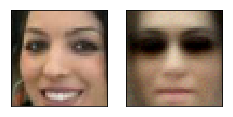

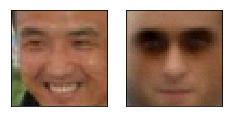

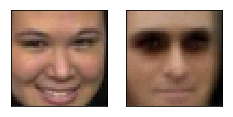

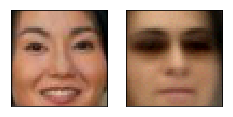

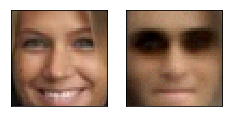

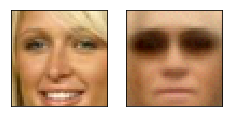

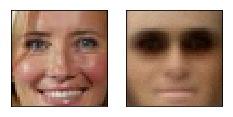

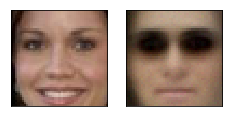

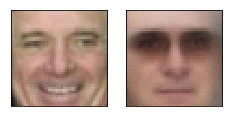

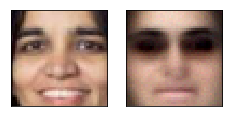

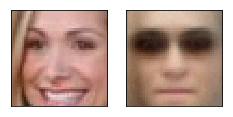

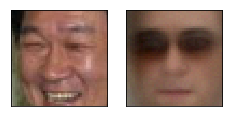

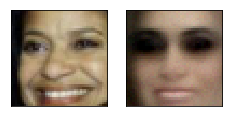

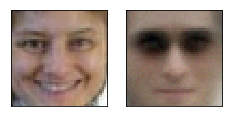

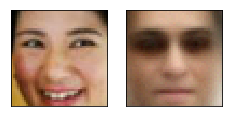

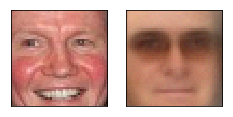

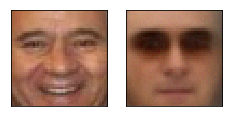

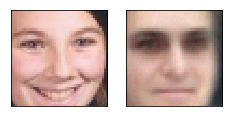

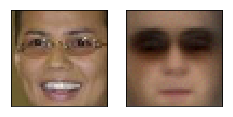

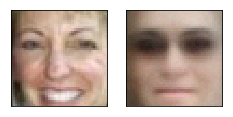

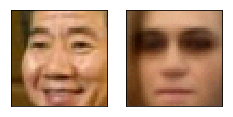

In [30]:
give_me_sunglasses(smile_ids)

While the concept is pretty straightforward the simple autoencoder have some disadvantages. Let's explore them and try to do better.

# Variational autoencoder

So far we have trained our encoder to reconstruct the very same image that we've transfered to latent space. That means that when we're trying to **generate** new image from the point decoder never met we're getting _the best image it can produce_, but the quelity is not good enough. 

> **In other words the encoded vectors may not be continuous in the latent space.**

In other hand Variational Autoencoders makes not only one encoded vector but **two**:
- vector of means, μ;
- vector of standard deviations, σ.

![https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png](https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png)

> picture from https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf



In [31]:
dim_z = 256

In [32]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [33]:
model_vae = VAE().to(DEVICE)

In [34]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001, min_lr=1e-5, factor=0.5, patience=5, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr, verbose=True)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))
            
            scheduler.step(val_loss)
    return history

In [37]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=75, batch_size=256, lr=0.001)

epoch:   0%|          | 0/75 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

# Conclusion

Variational autoencoders are cool. Although models in this particular notebook are simple they let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces and high-resolution digital artwork.
These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma et al. and Rezende et al.